In [1]:
import locale
locale.setlocale(locale.LC_NUMERIC, 'C')
import sys
sys.path.append('/Users/nwilming/u')
sys.path.append('/Users/nwilming/libcmaes/python/')
%pylab
%matplotlib inline
import seaborn as sns
from conf_analysis.behavior import normative as nrm, fstnrm as fast
sns.set_style('ticks')
%load_ext autoreload
%autoreload 2
%aimport -fast

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from conf_analysis.behavior import variance_misperception as vm

In [3]:
from scipy.stats import norm, t
import pandas as pd

def make_samples(w, N=1000, vars=[.5, 1, 1.5], threshold=0.75, adaptive=True):
    dfs = []
    if not adaptive:
        s = concatenate([randn(5000)*v for v in vars])            
        center = t(*t.fit(s)).ppf(threshold)
    for v in vars:
        if adaptive:
            center = norm.ppf(threshold, loc=0, scale=v)
        s1 = randn(N/2)*v + center
        s2 = randn(N/2)*v - center
        con = concatenate((s1, s2))
        side = concatenate((s1*0+1, s2*0))
        noise = concatenate((s1*0+v, s2*0 + v))
        dfs.append(pd.DataFrame({'mc':con, 'noise_sigma':noise, 'contrast':con*0 + center, 'side':side}))
    df =pd.concat(dfs)
    lpr = vm.logPR(w, df.mc, df.noise_sigma, df.contrast, vars)
    df.loc[:, 'choice'] = df['mc']>0
    df.loc[:, 'correct'] = df.choice == df.side
    df.loc[:, 'confidence'] = abs(lpr)>1.
    df.loc[:, 'snum']=1
    df.loc[:, 'lpr'] = lpr
    return df


In [4]:
df = make_samples(0, N=500, adaptive=True)
print df.correct.mean()

0.744


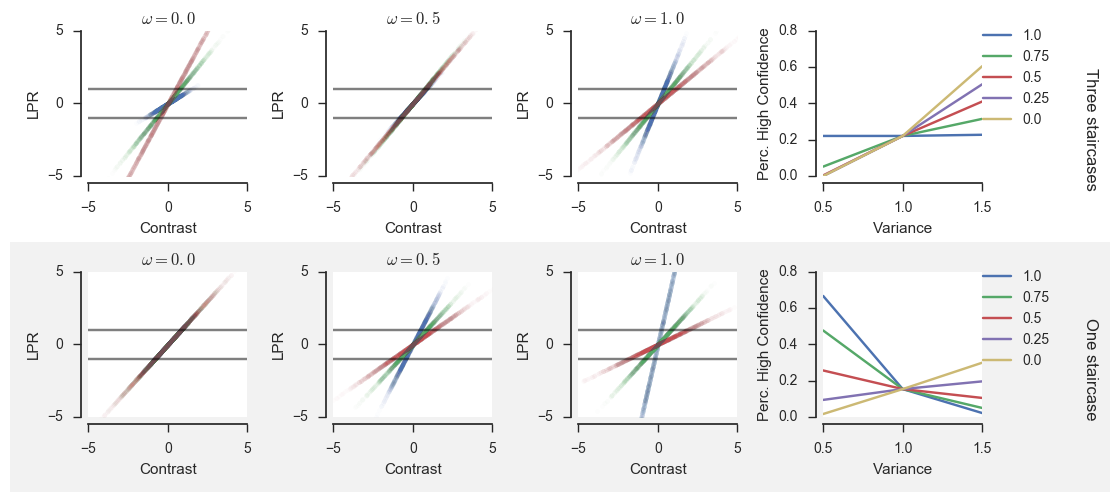

In [5]:
gs = matplotlib.gridspec.GridSpec(2, 4)
figure(figsize=(10, 5))
for j, a in enumerate([True, False]):
    for i, w in enumerate([0, 0.5, 1]):
        subplot(gs[j, i])
        df = make_samples(w, N=2500, adaptive=a)
        for _,c in df.groupby('noise_sigma'):
            plot(c.mc, c.lpr, '.', alpha=0.01)
        pyplot.locator_params(nbins=5)
        axhline(1, color='k', alpha=0.5)
        axhline(-1, color='k', alpha=0.5)
        xlabel('Contrast')
        ylabel('LPR')
        ylim([-5, 5])
        xlim([-5, 5])
        title(r'$\omega=%2.1f$'%w)

    subplot(gs[j, 3])
    for w in linspace(0,1.,5)[::-1]:
        l = vm.logPR(w, df.mc, df.noise_sigma, df.contrast, [0.5, 1., 1.5])
        df.loc[:, 'lpr'] = abs(l)>2
        plot(df.groupby('noise_sigma').lpr.mean(), label=w)
    xlabel('Variance')
    ylabel('Perc. High Confidence')
    legend(bbox_to_anchor=(1.5, 1.1))
    pyplot.locator_params(nbins=5)

sns.despine(offset=5)
tight_layout()

ax = gcf().add_axes([0,0, 1.1, .5])
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_zorder(-1000)
ax.patch.set_alpha(0.05)
ax.patch.set_color('k')
text(0.975, 0.65, 'One staircase',  rotation=270)
text(0.975, 1.65, 'Three staircases',  rotation=270)
sns.despine(left=True, bottom=True, ax=ax)

savefig('/Users/nwilming/u/conf_analysis/plots/variance_model_staircase.pdf', bbox_inches='tight')

In [6]:
w, s, r, target, predicted = vm.explicit(df.confidence, df.correct, df.mc, df.side-.5, df.noise_sigma, df.side)

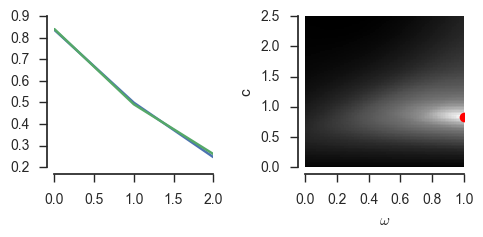

In [7]:
figure(figsize=(5, 2.5))
subplot(1,2,1)
plot(target)
plot(predicted)
subplot(1,2,2)
pcolor(w, s, log(r))
idx = argmin(r)
x, y = w.ravel()[idx], s.ravel()[idx]
plot(x, y, 'ro')
sns.despine(offset=5)
xlabel(r'$\omega$')
ylabel(r'c')
tight_layout()

In [8]:
import sys
sys.path.append('/Users/nwilming/u')
import cPickle
from conf_analysis.pupil import pupil, patsy_transforms as pt
from conf_analysis.behavior import empirical
from pylab import *
import seaborn as sns
import pandas as pd
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style('ticks')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
data = empirical.load_data()
data = empirical.data_cleanup(data)
def session_num(data):
    lt = dict((k, i) for i,k in enumerate(sort(unique(data.day))))
    data.loc[:, 'session_num'] = data.day
    data.session_num = data.session_num.replace(lt)
    return data

def block_num(data):
    lt = dict((k, i) for i,k in enumerate(sort(unique(data.session.astype('str')))))
    data.loc[:, 'block_num'] = data.session.astype('str')
    data.block_num = data.block_num.replace(lt)
    return data

data = data.groupby('snum').apply(session_num)
data = data.groupby(['snum', 'session_num']).apply(block_num)
def zscore_contrast(data):
    con = vstack(data.contrast_probe)
    m = mean(con)
    s = abs(con-mean(con)).std()
    idx = where(data.columns=='contrast_probe')[0][0]
    for i in range(len(data)): 
        data['contrast_probe'].values[i] = (data.iloc[i, idx]-m)/s
    return data

dz = data.groupby('snum').apply(zscore_contrast)
dz['mc'] = array([mean(k) for k in dz.contrast_probe.values])
dz['stdc'] = array([std(k) for k in dz.contrast_probe.values])


In [10]:
dz = dz[~isnan(dz.correct)]

In [11]:
unique(dz.correct)
mcadjusted = dz.mc.values.copy()
mcadjusted[dz.side.values==-1] *= -1
vm.fit_sigma(dz.correct.astype(bool), mcadjusted)

     fun: 7139.38963391443
 message: 'Solution found.'
    nfev: 34
  status: 0
 success: True
       x: 1.205128868319979

In [12]:
print abs(dz.mc).mean()

0.770639189038


In [13]:
def foo(data):
    threshold = mean(abs(data.mc))
    w, s, r, target, predicted = vm.explicit(data.confidence-1, data.correct,
                                             data.mc, threshold, data.noise_sigma, data.side==1)
    m = argmin(r.ravel())
    return pd.DataFrame({'w':[w.ravel()[m]], 'cut':[s.ravel()[m]], 'target':[target], 'predicted':[predicted]})

params = dz.groupby(['snum']).apply(foo)

In [14]:
ws = [params.loc[snum, :].w.values[0] for snum in range(1, 15)]
sub_order = argsort(ws)

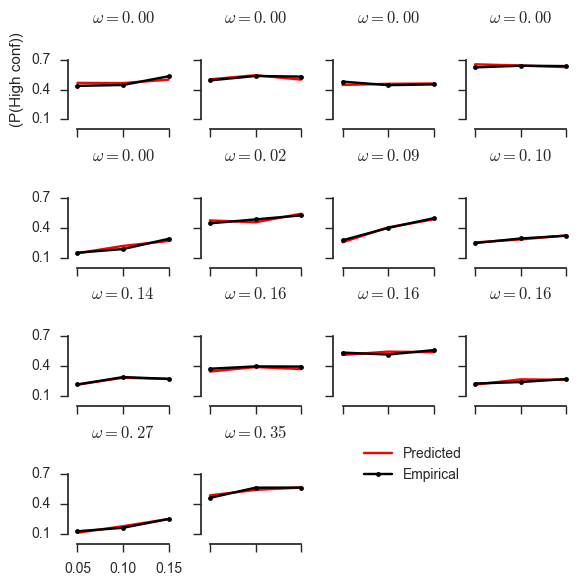

In [15]:
figure(figsize=(6,6))

for i, sub in enumerate(sub_order):
    subd,  p = dz.query('snum==%i'%(sub+1)), params.loc[sub+1]
    subplot(4, 4, i+1)
    predicted = p.predicted.values[0]
    target = p.target.values[0]
    plot([0.05, 0.1, 0.15], predicted, 'r', label='Predicted')
    plot([0.05, 0.1, 0.15], target, 'k.-', label='Empirical')
    if i == 0:
        ylabel(r'(P(High conf))')
    if i == 12:
        xticks([.05, .1, .15])
    else:
        xticks([.05, .1, .15], [])
    if mod(i, 4)==0:
        yticks([0.1, 0.4, 0.7])
    else:
        yticks([0.1, 0.4, 0.7], [])
    ylim([0.0, 1])
    title(r'$\omega=%2.2f$'%round(ws[sub], 3))
sns.despine(trim=True)
legend(bbox_to_anchor=(2.5, 1.1))
tight_layout()
savefig('/Users/nwilming/u/conf_analysis/plots/variance_misperceptiont.pdf', bbox_inches='tight')

In [16]:
dz.loc[:, 'IDblock'] = (dz.session_num*5) + dz.block_num

In [17]:
params_time = dz.groupby(['snum', 'session_num']).apply(foo)

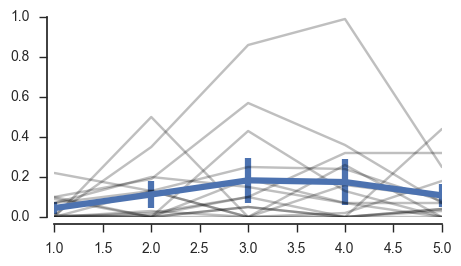

In [18]:
figure(figsize=(5, 2.5))
tt = params_time.reset_index().pivot_table(index='session_num', columns='snum', values='w')
#print tt
sem = tt.std(1)/(tt.shape[0]**.5)
plot(arange(len(sem))+1, tt, 'k', alpha=0.25)
errorbar(arange(len(sem))+1, tt.mean(1), yerr=1*sem, lw=4.5)

#xlim([0.99, 5.01])
sns.despine(offset=5)


In [27]:
print params.w
print mean(params.w.values), std(params.w.values)


snum   
1     0    0.16
2     0    0.10
3     0    0.16
4     0    0.00
5     0    0.16
6     0    0.02
7     0    0.00
8     0    0.35
9     0    0.00
10    0    0.00
11    0    0.27
12    0    0.00
13    0    0.14
14    0    0.09
15    0    0.17
Name: w, dtype: float64
0.108 0.104639062177
